# MRR Implementation 

In [19]:
!pip3 install numpy
!pip3 install numba
!pip3 install pandas

import numpy as np
import numba as nb
np.random.seed(2)

def generate_subsample(top_k: int, users_count: int, gt_count: int = 1):
  users = np.arange(0, users_count)
  user_to_many_records = np.repeat(users, gt_count)
  np.random.shuffle(user_to_many_records)
  targets = np.stack([user_to_many_records,
                      np.random.randint(0, 50, len(user_to_many_records))])
  predicts = np.random.randint(0, 50, (users_count, top_k))

  assert len(predicts) == len(users)
  assert len(np.unique(targets[0, :]) == len(predicts))
  
  return users, targets, predicts


You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.


In [20]:
users, targets, predicts = generate_subsample(10, 100)

## Naive

In [21]:
def naive_mrr(users, targets, predicts, k):
  
  per_user_mrr = np.zeros(users.shape[0])

  for user in users:
    user_targets = targets[1, :][targets[0, :] == user]
    predict_positions = np.ones(user_targets.shape[0]) * k

    for target_idx, user_target in enumerate(user_targets):
      positional_idxes = np.where(predicts[user][:k] == user_target)[0]

      if (len(positional_idxes) != 0):
        predict_positions[target_idx] = positional_idxes.min()

    best_position = predict_positions.min()

    if best_position == k:
      per_user_mrr[user] = 0
    else:
      per_user_mrr[user] =  1 / (best_position + 1)
      
  return per_user_mrr.mean()

In [22]:
naive_mrr(users, targets, predicts, 10)

0.0794563492063492

In [23]:
%time naive_mrr(users, targets, predicts, 10)

CPU times: user 5.06 ms, sys: 620 µs, total: 5.68 ms
Wall time: 5.66 ms


0.0794563492063492

## Numba

In [24]:
@nb.njit(cache=True, parallel=True, nopython=True, fastmath=True)
def numba_mrr(users, targets, predicts, k):
  
  per_user_mrr = np.zeros(users.shape[0])

  for user in nb.prange(users.shape[0]):
    user_targets = targets[1, :][targets[0, :] == user]
    predict_positions = np.ones(user_targets.shape[0]) * k
  
    for target_idx, user_target in enumerate(user_targets):
      positional_idxes = np.where(predicts[user][:k] == user_target)[0]

      if positional_idxes.shape[0] != 0:
        predict_positions[target_idx] = positional_idxes.min()

    best_position = predict_positions.min()

    if best_position == k:
      per_user_mrr[user] = 0
    else:
      per_user_mrr[user] =  1 / (best_position + 1)
      
  return per_user_mrr.mean()

/home/evgenii/repos/ed/RecoServiceTeam30/venv/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [25]:
# pre compile
numba_mrr(users[:10], targets[:10], predicts[:10], 10)

0.0225

In [26]:
%time numba_mrr(users, targets, predicts, 10)

CPU times: user 40.1 ms, sys: 0 ns, total: 40.1 ms
Wall time: 3.17 ms


0.0794563492063492

## Pandas

In [27]:
import pandas as pd

In [28]:
def pandas_mrr(targets, predicts, k):
  
  # preprocess data
  df = pd.DataFrame(data={"Users": targets[0], "item": targets[1]})

  predicted_users = np.repeat(list(range(0, len(np.unique(targets[0])))),
                              predicts.shape[1])
  
  predicts = pd.DataFrame(data={"Users": predicted_users, 
                                "item": predicts.ravel()})
  
  # logic
  predicts["position"] = predicts.groupby("Users")["Users"].rank(method='first')
  predicts = predicts[predicts["position"] <= k] 
  df_recs = df.merge(predicts, how='left')
  metric = (1 / df_recs.groupby("Users")["position"].min()).fillna(0)

  return metric.mean()


In [29]:
%time pandas_mrr(targets, predicts, 10)

CPU times: user 14.3 ms, sys: 1.32 ms, total: 15.6 ms
Wall time: 188 ms


0.0794563492063492

# Validate

In [30]:
!pip3 install matplotlib
import matplotlib.pyplot as plt
import time

You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.


In [31]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100, 1000]

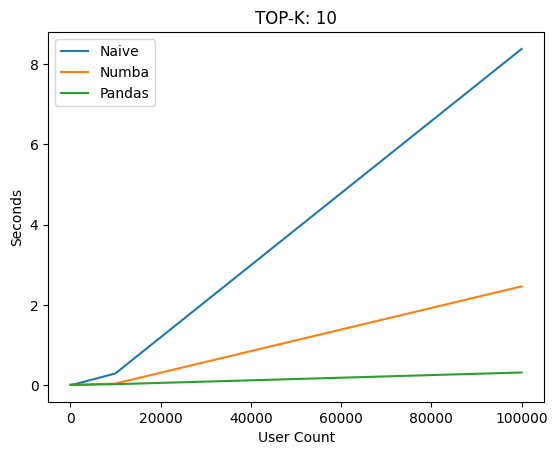

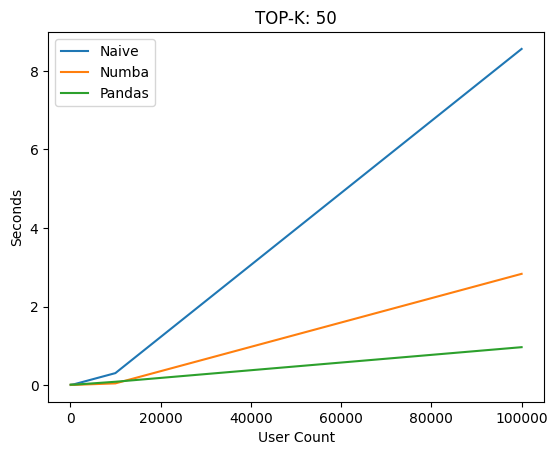

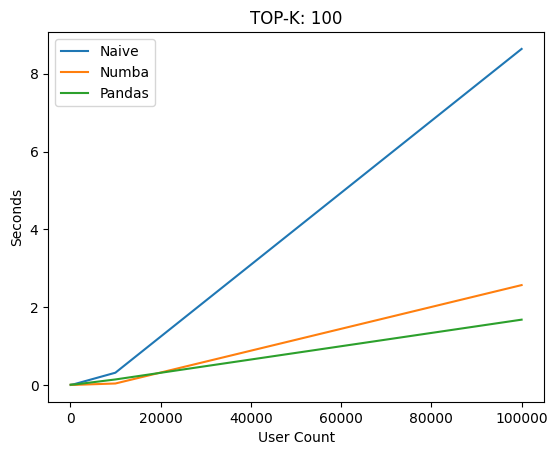

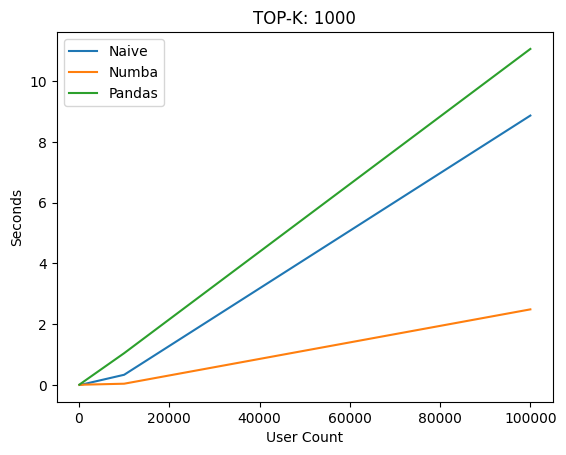

In [32]:
for k in top_k:
  naive_times = []
  numba_times = []
  pandas_times = []
  for user_count in users_count:
     users, targets, predicts = generate_subsample(k, user_count)
     # naive
     start = time.time()
     naive = naive_mrr(users, targets, predicts, k)
     naive_times.append(time.time() - start)
     # numba
     start = time.time()
     numba = numba_mrr(users, targets, predicts, k)
     numba_times.append(time.time() - start)
     # pandas
     start = time.time()
     pandas = pandas_mrr(targets, predicts, k)
     pandas_times.append(time.time() - start)
     assert round(naive, 3) == round(numba, 3) == round(pandas, 3)
  plt.plot(users_count, naive_times, label="Naive")
  plt.plot(users_count, numba_times, label="Numba")
  plt.plot(users_count, pandas_times, label="Pandas")
  plt.legend()
  plt.xlabel("User Count")
  plt.ylabel("Seconds")
  plt.title(f"TOP-K: {k}")

  plt.show()
